## Retrievability Experiment on TREC678

In this notebook, I aim to do or change following things:
* change unigram queries generation; complies sir's directions  -> Done!
* change bigram queries generation; MyCorpus class using IndexSearcher  -> Done!
* Equal number of queries from each docs? -> Not now. Require use of cutoff per doc using an importance measure.
* BM25 query weights for filtering? -> Not now. Non-trivial implementation will be required.
* do Retrievability analysis for more Retrieval models available on lucene -> sir told that no more is required
* do Retrievability analysis for query expansion (maybe on new version of this file) -> sir asked to do for RM3
* check r(d) summary statistics for judged vs non-judged docs
* MAP vs Gini Coefficient tabulation

In [1]:
import lucene
from org.apache.lucene.search import IndexSearcher
from org.apache.lucene.index import DirectoryReader
from org.apache.lucene.index import MultiTerms
from org.apache.lucene.store import FSDirectory
from org.apache.lucene.queryparser.classic import QueryParser
from org.apache.lucene.search.similarities import BM25Similarity
from org.apache.lucene.search.similarities import ClassicSimilarity
from org.apache.lucene.search.similarities import LMJelinekMercerSimilarity
from org.apache.lucene.search.similarities import LMDirichletSimilarity
from org.apache.lucene.analysis.en import EnglishAnalyzer
from java.io import File

from org.apache.lucene.search import BooleanQuery
from org.apache.lucene.search import BooleanClause
from org.apache.lucene.search import TermQuery
from org.apache.lucene.search import BoostQuery
from org.apache.lucene.index import Term

from org.apache.lucene.util import BytesRefIterator

In [2]:
# starting lucene virtual machine
lucene.initVM()

In [3]:
# Lucene index of the corpus
index_path = '../index/'
directory = FSDirectory.open(File(index_path).toPath())
indexReader = DirectoryReader.open(directory)

FIELDNAME = 'CONTENT'       # Lucene index field name
N = 528155                  # no. docs in TREC678 or in the index

In [4]:
from collections import Counter
import pickle
import nltk

### Query Generation

#### Unigram queries

In [5]:
class MyCorpus:
    def __init__(self, corpusDirectory):
        # Corpus documents directory path
        self.dirPath = corpusDirectory
        self.N = 528155
        self.docCount = 0
    
    def __iter__(self):
        for luceneDocid in range(self.N):
            yield indexReader.document(luceneDocid).get(FIELDNAME)

In [20]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Corpus documents directory path
dirPath = '../../TREC678/documents_robust04/'
trec_corpus = MyCorpus(corpusDirectory=dirPath)

unigram_counter = Counter()      # to store unigrams with their frequencies

stop_words = stopwords.words('english')
stopwords_set = set(stop_words)
stopwords_set.remove('won')

count_doc = 0
for doc in trec_corpus:
    count_doc += 1
    # text pre-processing:
    tokens = word_tokenize(doc)
    # stopword removal and non-alphabetical token removal
    words = [w.lower() for w in tokens if (w.isalpha() and (w.lower() not in stopwords_set))]
    # pos_tag filtering
    word_tag_pairs = nltk.tag.pos_tag(words, tagset='universal')
    filter_tags = ['ADJ','ADP','ADV','CONJ','DET','NUM','PRT','PRON','VERB']
    words = [word for word,tag in word_tag_pairs if tag not in filter_tags]
    # add to Counter
    unigram_counter.update(words)
    # stdout count_doc logging
    if count_doc%(N//10)==0:
        print(f'At #doc = {count_doc}; progress... {count_doc*100/N:.2f}%')

print(f'\nNumber of docs covered during unigram sampling = {count_doc}. Docs covered {count_doc*100/N:.2f}%')

tf_cutoff = 5
limit = 2000000     # 2 million -> #unigram limit
unigram_list = sorted([x for x in unigram_counter.items() if x[1]>=tf_cutoff], reverse=True, key=lambda lst: lst[1])[:limit]
unigram_queries = [x[0] for x in unigram_list if len(x[0])>1]
        
print(f'Number of unigrams samples = {len(unigram_queries)}')

upto #doc = 52815; progress... 10.00%
upto #doc = 105630; progress... 20.00%
upto #doc = 158445; progress... 30.00%
upto #doc = 211260; progress... 40.00%
upto #doc = 264075; progress... 50.00%
upto #doc = 316890; progress... 60.00%
upto #doc = 369705; progress... 70.00%
upto #doc = 422520; progress... 80.00%
upto #doc = 475335; progress... 90.00%
upto #doc = 528150; progress... 100.00%

Number of docs covered during unigram sampling = 528155. Docs covered 100.00%
Number of unigrams samples = 137054


In [26]:
# write unigram_queries to disk
with open('./Queries/unigram_queries_isalpha_tf5_not-analyzed_pos-filtered.txt', 'w') as f:
    f.write('\n'.join(unigram_queries))
    f.write('\n')
    
with open(f'./Queries/unigram_queries_isalpha_tf5_not-analyzed_pos-filtered.pickle', 'wb') as f:
        pickle.dump(unigram_queries, f)

In [7]:
# Load unigram queries from pickle dump
with open('./Queries/unigram_queries_isalpha_tf5_not-analyzed_pos-filtered.pickle', 'rb') as f:
    unigram_queries = pickle.load(f)

In [25]:
# no. of unigram queries
len(unigram_queries)

137029

#### Bigram queries

In [41]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.regexp import blankline_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter

# Corpus documents directory path
dirPath = '../../TREC678/documents_robust04/'
trec_corpus = MyCorpus(corpusDirectory=dirPath)

bigram_counter = Counter()      # to store bigrams with their frequencies

stop_words = stopwords.words('english')
stopwords_set = set(stop_words)
stopwords_set.remove('won')

count_doc = 0
for doc in trec_corpus:
    count_doc += 1
    # text pre-processing:
    # blankline tokenization, then sentence tokenization, then word tokenization
    sents_nested = [sent_tokenize(ss) for ss in blankline_tokenize(doc)]
    sents = [sent for sublist in sents_nested for sent in sublist]
    tokens_nested = [word_tokenize(s) for s in sents]
    # stopword removal and tokens with non-alphanum chars removed
    tokens_nested = [[token.lower() for token in sent_tokens if any(char.isalnum() for char in token) and token.lower() not in stopwords_set] for sent_tokens in tokens_nested]
    # bigram sampling one sentence at a time
    for tokens in tokens_nested:
        bi_grams = ngrams(tokens, 2)
        # non-alphabetical bigram removal
        bi_grams = [bigram for bigram in bi_grams if bigram[0].isalpha() and bigram[1].isalpha()]
        # pos_tag filtering
        filter_tags = ['ADP','CONJ','DET','NUM','PRT','PRON','VERB']
        bi_grams = [bigram for bigram in bi_grams if not any([tag in filter_tags for _,tag in nltk.tag.pos_tag(bigram, tagset='universal')])]
        # add bigrams into counter
        bigram_counter.update(bi_grams)
    # stdout count_doc logging
    if count_doc%(N//20)==0:
        print(f'At #doc = {count_doc}; progress... {count_doc*100/N:.2f}%')

print(f'\nNumber of docs covered during bigram sampling = {count_doc}. Docs covered {count_doc*100/N:.2f}%')

tf_cutoff = 20
limit = 2000000     # 2 million -> #bigram limit
bigram_list = sorted([x for x in bigram_counter.items() if x[1]>=tf_cutoff], reverse=True, key=lambda lst: lst[1])[:limit]
bigram_queries = [' '.join(x[0]) for x in bigram_list]

print(f'Number of bigrams sampled = {len(bigram_queries)}')

At #doc = 26407; progress... 5.00%
At #doc = 52814; progress... 10.00%
At #doc = 79221; progress... 15.00%
At #doc = 105628; progress... 20.00%
At #doc = 132035; progress... 25.00%
At #doc = 158442; progress... 30.00%
At #doc = 184849; progress... 35.00%
At #doc = 211256; progress... 40.00%
At #doc = 237663; progress... 45.00%
At #doc = 264070; progress... 50.00%
At #doc = 290477; progress... 55.00%
At #doc = 316884; progress... 60.00%
At #doc = 343291; progress... 65.00%
At #doc = 369698; progress... 70.00%
At #doc = 396105; progress... 75.00%
At #doc = 422512; progress... 80.00%
At #doc = 448919; progress... 85.00%
At #doc = 475326; progress... 90.00%
At #doc = 501733; progress... 95.00%
At #doc = 528140; progress... 100.00%

Number of docs covered during bigram sampling = 528155. Docs covered 100.00%
Number of bigrams sampled = 449708


In [44]:
# filtering out bigrams with a term of just one char
bigram_queries = [bigram for bigram in bigram_queries if len(bigram.split()[0])>1 and len(bigram.split()[1])>1]

In [10]:
bigram_queries = [bigram for bigram in bigram_queries if bigram.split()[0] != bigram.split()[1]]

In [11]:
# write unigram_queries to disk
with open('./Queries/bigram_queries_isalpha_tf20_not-analyzed_pos-filtered.txt', 'w') as f:
    f.write('\n'.join(bigram_queries))
    f.write('\n')
    
with open(f'./Queries/bigram_queries_isalpha_tf20_not-analyzed_pos-filtered.pickle', 'wb') as f:
        pickle.dump(bigram_queries, f)

In [9]:
len(bigram_queries)

447183

### Retrievability: Retrievals

* BM25, TFIDF, LMDir again with the new query set
* Correlation coefficients: Pearson's rho, Spearman's r, Kendall's Tau, RBO (Rank Biased Overlap) measure

In [15]:
import pickle
from collections import Counter

def retrievability_experiment(similarityModel, corpusIndexPath, c, queryFilePaths_and_noOfQueries_tuple, analyzer):
    directory = FSDirectory.open(File(corpusIndexPath).toPath())
    searcher = IndexSearcher(DirectoryReader.open(directory))
    searcher.setSimilarity(similarityModel)
    
    r_d = Counter()     # to store lucene_docids and their cumulative counts
    
    def retrieve(query, c, r_d):
        escaped_q = QueryParser(FIELDNAME, analyzer).escape(query)
        q = QueryParser(FIELDNAME, analyzer).parse(escaped_q)

        # getting the top c search results using the searcher
        scoreDocs = searcher.search(q, c).scoreDocs

        lucene_docids = []
        for scoreDoc in scoreDocs:
            lucene_docids.append(scoreDoc.doc)

        r_d.update(lucene_docids)
    
    for item in queryFilePaths_and_noOfQueries_tuple:
        filePath = item[0]
        len_queries = item[1]
        if 'unigram' in filePath:
            query_type = 'Unigram queries'
        elif 'bigram' in filePath:
            query_type = 'Bigram queries'
        
        print(f"{query_type} run starts...")
        with open(filePath) as f:
            i = 0
            for line in f:
                query = line[:-1]
                retrieve(query, c, r_d)
                
                i += 1
                if i%(len_queries//20)==0:
                    print(f"{query_type} progress... {i*100/len_queries: .2f}%")
            print(f'Run completed with {query_type} progress... {i*100/len_queries: .2f}%')

    with open(f'./rd_dumps/rd_queryset2_{model}_{c}.pickle', 'wb') as f:
        pickle.dump(r_d, f)
        
    return r_d

In [16]:
# Retrievability Experiment for various cutoff rank c

analyzer = EnglishAnalyzer()    # used same analyzer as indexer

model = 'lmdir'
mu = 1000.0
similarityModel = LMDirichletSimilarity(mu)   # LM with Bayes Smoothing Dirchlet Similarity

query_set_files = ['./Queries/unigram_queries_isalpha_tf5_not-analyzed_pos-filtered.txt', './Queries/bigram_queries_isalpha_tf20_not-analyzed_pos-filtered.txt']
queryPath_len_tuple = [(path, sum(1 for _ in open(path))) for path in query_set_files]  # [('filename.txt',num_of_queries)]

all_rd = dict()
c_list  = [10,20,30,50,100]
for c in c_list:
    print(f'{model} retrievals starting for c = {c}\n')
    all_rd[f'r_d_{model}_{c}'] = retrievability_experiment(similarityModel,index_path,c,queryPath_len_tuple,analyzer)
    print(f'Completed! c = {c}\n')

lmdir retrievals starting for c = 10

Unigram queries run starts...
Unigram queries progress...  5.00%
Unigram queries progress...  10.00%
Unigram queries progress...  15.00%
Unigram queries progress...  20.00%
Unigram queries progress...  25.00%
Unigram queries progress...  30.00%
Unigram queries progress...  35.00%
Unigram queries progress...  40.00%
Unigram queries progress...  45.00%
Unigram queries progress...  50.00%
Unigram queries progress...  55.00%
Unigram queries progress...  60.00%
Unigram queries progress...  65.00%
Unigram queries progress...  70.00%
Unigram queries progress...  75.00%
Unigram queries progress...  79.99%
Unigram queries progress...  84.99%
Unigram queries progress...  89.99%
Unigram queries progress...  94.99%
Unigram queries progress...  99.99%
Run completed with Unigram queries progress...  100.00%
Bigram queries run starts...
Bigram queries progress...  5.00%
Bigram queries progress...  10.00%
Bigram queries progress...  15.00%
Bigram queries progress.

LMDIR, c = 10: Gini Coefficient, G = 0.7118
LMDIR, c = 20: Gini Coefficient, G = 0.6757
LMDIR, c = 30: Gini Coefficient, G = 0.6566
LMDIR, c = 50: Gini Coefficient, G = 0.6338
LMDIR, c = 100: Gini Coefficient, G = 0.6040


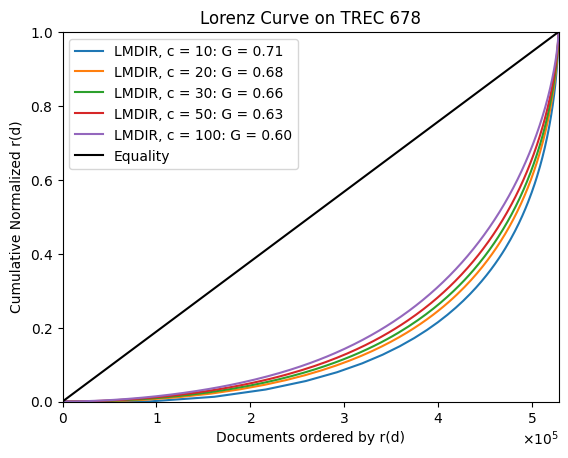

In [17]:
from operator import itemgetter
import numpy as np
import matplotlib.pyplot as plt


N = 528155      # No. of docs in Corpus
X = np.arange(N)    # No. of docs array
equality = np.cumsum(np.full(N, 1.0/N))

# all_rd = {}
# for c in c_list:
#     with open(f'./rd_{c}_{model}.pickle', 'rb') as f:
#         all_rd[f'r_d_{c}'] = pickle.load(f)

for c in c_list:
    
    r_d = all_rd[f'r_d_{model}_{c}']
    
    # setting non-retrieved documents' retrieval count to zero and including them in r_d
    for num in range(N):
        r_d[num] = r_d.get(num, 0)

    r_d_sorted = sorted(r_d.most_common(), key=itemgetter(1))    # r(d) in ascending order with lucene-docids
    
    # Gini Coefficient G
    G = sum([(2*i-N-1)*r_d_sorted[i-1][1] for i in range(1,N+1)])/(N*sum([r_d_sorted[j-1][1] for j in range(1,len(r_d_sorted)+1)]))
    print(f'{model.upper()}, c = {c}: Gini Coefficient, G = {G:.4f}')

    # Lorenz Curve of r(d) scores
    Y = np.cumsum([item[1] for item in r_d_sorted])    # Cumulative sum of ascending sorted r(d) values
    Y = Y/np.max(Y)
    plt.plot(X,Y,'-', label=f'{model.upper()}, c = {c}: G = {G:.2f}')
    
plt.plot(X,equality,'-', label='Equality', color='black')
plt.legend(loc='upper left')
plt.title('Lorenz Curve on TREC 678')
plt.xlabel('Documents ordered by r(d)')
plt.ylabel('Cumulative Normalized r(d)')
plt.margins(x=0,y=0)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
plt.savefig(f'./Lorenz_curves/lorenz_curve_queryset2_{model}.png', facecolor='white', transparent=False, dpi=300)
plt.show()

In [18]:
# Retrievability Experiment for various cutoff rank c

# setting up the searcher
analyzer = EnglishAnalyzer()    # used same analyzer as indexer

model = 'bm25'
k1 = 0.7; b = 0.35       # optimal params from evaluations on topics 678-robust 250 queries
similarityModel = BM25Similarity(k1,b)   # BM25 Similarity

query_set_files = ['./Queries/unigram_queries_isalpha_tf5_not-analyzed_pos-filtered.txt', './Queries/bigram_queries_isalpha_tf20_not-analyzed_pos-filtered.txt']
queryPath_len_tuple = [(path, sum(1 for _ in open(path))) for path in query_set_files]  # [('filename.txt',num_of_queries)]

all_rd = dict()
c_list  = [10,20,30,50,100]
for c in c_list:
    print(f'{model} retrievals starting for c = {c}\n')
    all_rd[f'r_d_{model}_{c}'] = retrievability_experiment(similarityModel,index_path,c,queryPath_len_tuple,analyzer)
    print(f'Completed! c = {c}\n')

bm25 retrievals starting for c = 10

Unigram queries run starts...
Unigram queries progress...  5.00%
Unigram queries progress...  10.00%
Unigram queries progress...  15.00%
Unigram queries progress...  20.00%
Unigram queries progress...  25.00%
Unigram queries progress...  30.00%
Unigram queries progress...  35.00%
Unigram queries progress...  40.00%
Unigram queries progress...  45.00%
Unigram queries progress...  50.00%
Unigram queries progress...  55.00%
Unigram queries progress...  60.00%
Unigram queries progress...  65.00%
Unigram queries progress...  70.00%
Unigram queries progress...  75.00%
Unigram queries progress...  79.99%
Unigram queries progress...  84.99%
Unigram queries progress...  89.99%
Unigram queries progress...  94.99%
Unigram queries progress...  99.99%
Run completed with Unigram queries progress...  100.00%
Bigram queries run starts...
Bigram queries progress...  5.00%
Bigram queries progress...  10.00%
Bigram queries progress...  15.00%
Bigram queries progress..

BM25, c = 10: Gini Coefficient, G = 0.6139
BM25, c = 20: Gini Coefficient, G = 0.5768
BM25, c = 30: Gini Coefficient, G = 0.5567
BM25, c = 50: Gini Coefficient, G = 0.5329
BM25, c = 100: Gini Coefficient, G = 0.5031


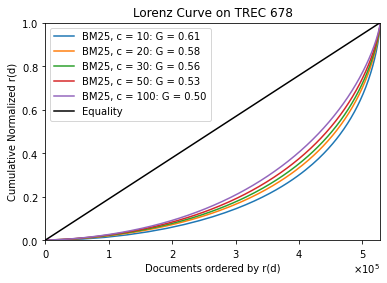

In [8]:
from operator import itemgetter
import numpy as np
import matplotlib.pyplot as plt

model = 'bm25'

N = 528155      # No. of docs in Corpus
X = np.arange(N)    # No. of docs array
equality = np.cumsum(np.full(N, 1.0/N))

c_list  = [10,20,30,50,100]
all_rd = {}
for c in c_list:
    with open(f'./rd_dumps/rd_{c}_{model}.pickle', 'rb') as f:
        all_rd[f'r_d_{model}_{c}'] = pickle.load(f)

for c in c_list:
    
    r_d = all_rd[f'r_d_{model}_{c}']
    
    # setting non-retrieved documents' retrieval count to zero and including them in r_d
    for num in range(N):
        r_d[num] = r_d.get(num, 0)

    r_d_sorted = sorted(r_d.most_common(), key=itemgetter(1))    # r(d) in ascending order with lucene-docids
    
    # Gini Coefficient G
    G = sum([(2*i-N-1)*r_d_sorted[i-1][1] for i in range(1,N+1)])/(N*sum([r_d_sorted[j-1][1] for j in range(1,len(r_d_sorted)+1)]))
    print(f'{model.upper()}, c = {c}: Gini Coefficient, G = {G:.4f}')

    # Lorenz Curve of r(d) scores
    Y = np.cumsum([item[1] for item in r_d_sorted])    # Cumulative sum of ascending sorted r(d) values
    Y = Y/np.max(Y)
    plt.plot(X,Y,'-', label=f'{model.upper()}, c = {c}: G = {G:.2f}')
    
plt.plot(X,equality,'-', label='Equality', color='black')
plt.legend(loc='upper left')
plt.title('Lorenz Curve on TREC 678')
plt.xlabel('Documents ordered by r(d)')
plt.ylabel('Cumulative Normalized r(d)')
plt.margins(x=0,y=0)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
plt.savefig(f'./Lorenz_curves/lorenz_curve_queryset2_{model}.png', facecolor='white', transparent=False, dpi=300)
plt.show()

In [20]:
# Retrievability Experiment for various cutoff rank c

# setting up the searcher
analyzer = EnglishAnalyzer()    # used same analyzer as indexer

model = 'tfidf'
similarityModel = ClassicSimilarity()   # TFIDF Similarity

query_set_files = ['./Queries/unigram_queries_isalpha_tf5_not-analyzed_pos-filtered.txt', './Queries/bigram_queries_isalpha_tf20_not-analyzed_pos-filtered.txt']
queryPath_len_tuple = [(path, sum(1 for _ in open(path))) for path in query_set_files]  # [('filename.txt',num_of_queries)]

all_rd = dict()
c_list  = [10,20,30,50,100]
for c in c_list:
    print(f'{model} retrievals starting for c = {c}\n')
    all_rd[f'r_d_{model}_{c}'] = retrievability_experiment(similarityModel,index_path,c,queryPath_len_tuple,analyzer)
    print(f'Completed! c = {c}\n')

tfidf retrievals starting for c = 10

Unigram queries run starts...
Unigram queries progress...  5.00%
Unigram queries progress...  10.00%
Unigram queries progress...  15.00%
Unigram queries progress...  20.00%
Unigram queries progress...  25.00%
Unigram queries progress...  30.00%
Unigram queries progress...  35.00%
Unigram queries progress...  40.00%
Unigram queries progress...  45.00%
Unigram queries progress...  50.00%
Unigram queries progress...  55.00%
Unigram queries progress...  60.00%
Unigram queries progress...  65.00%
Unigram queries progress...  70.00%
Unigram queries progress...  75.00%
Unigram queries progress...  79.99%
Unigram queries progress...  84.99%
Unigram queries progress...  89.99%
Unigram queries progress...  94.99%
Unigram queries progress...  99.99%
Run completed with Unigram queries progress...  100.00%
Bigram queries run starts...
Bigram queries progress...  5.00%
Bigram queries progress...  10.00%
Bigram queries progress...  15.00%
Bigram queries progress.

TFIDF, c = 10: Gini Coefficient, G = 0.6715
TFIDF, c = 20: Gini Coefficient, G = 0.6201
TFIDF, c = 30: Gini Coefficient, G = 0.5922
TFIDF, c = 50: Gini Coefficient, G = 0.5577
TFIDF, c = 100: Gini Coefficient, G = 0.5112


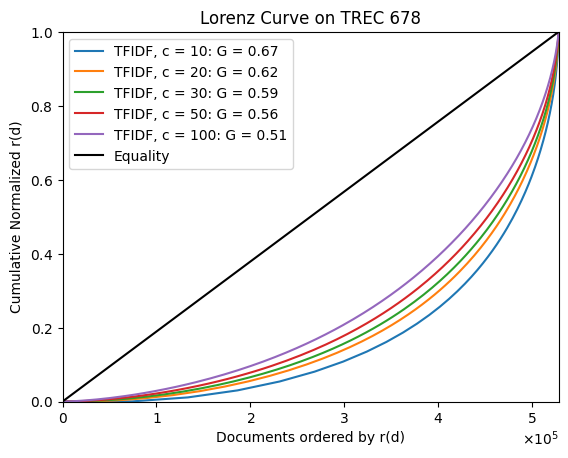

In [21]:
from operator import itemgetter
import numpy as np
import matplotlib.pyplot as plt


N = 528155      # No. of docs in Corpus
X = np.arange(N)    # No. of docs array
equality = np.cumsum(np.full(N, 1.0/N))

# all_rd = {}
# for c in c_list:
#     with open(f'./rd_{c}_{model}.pickle', 'rb') as f:
#         all_rd[f'r_d_{c}'] = pickle.load(f)

for c in c_list:
    
    r_d = all_rd[f'r_d_{model}_{c}']
    
    # setting non-retrieved documents' retrieval count to zero and including them in r_d
    for num in range(N):
        r_d[num] = r_d.get(num, 0)

    r_d_sorted = sorted(r_d.most_common(), key=itemgetter(1))    # r(d) in ascending order with lucene-docids
    
    # Gini Coefficient G
    G = sum([(2*i-N-1)*r_d_sorted[i-1][1] for i in range(1,N+1)])/(N*sum([r_d_sorted[j-1][1] for j in range(1,len(r_d_sorted)+1)]))
    print(f'{model.upper()}, c = {c}: Gini Coefficient, G = {G:.4f}')

    # Lorenz Curve of r(d) scores
    Y = np.cumsum([item[1] for item in r_d_sorted])    # Cumulative sum of ascending sorted r(d) values
    Y = Y/np.max(Y)
    plt.plot(X,Y,'-', label=f'{model.upper()}, c = {c}: G = {G:.2f}')
    
plt.plot(X,equality,'-', label='Equality', color='black')
plt.legend(loc='upper left')
plt.title('Lorenz Curve on TREC 678')
plt.xlabel('Documents ordered by r(d)')
plt.ylabel('Cumulative Normalized r(d)')
plt.margins(x=0,y=0)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
plt.savefig(f'./Lorenz_curves/lorenz_curve_queryset2_{model}.png', facecolor='white', transparent=False, dpi=300)
plt.show()

BM25, c = 100: Gini Coefficient, G = 0.5031


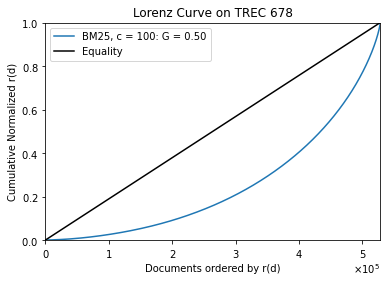

In [5]:
import pickle
from operator import itemgetter
import numpy as np
import matplotlib.pyplot as plt

model = 'bm25'

N = 528155      # No. of docs in Corpus
X = np.arange(N)    # No. of docs array
equality = np.cumsum(np.full(N, 1.0/N))

all_rd = {}
for c in [100]:
    with open(f'./rd_dumps/rd_100_bm25.pickle', 'rb') as f:
        all_rd[f'r_d_{model}_{c}'] = pickle.load(f)

for c in [100]:
    
    r_d = all_rd[f'r_d_{model}_{c}']
    
    # setting non-retrieved documents' retrieval count to zero and including them in r_d
    for num in range(N):
        r_d[num] = r_d.get(num, 0)

    r_d_sorted = sorted(r_d.most_common(), key=itemgetter(1))    # r(d) in ascending order with lucene-docids
    
    # Gini Coefficient G
    G = sum([(2*i-N-1)*r_d_sorted[i-1][1] for i in range(1,N+1)])/(N*sum([r_d_sorted[j-1][1] for j in range(1,len(r_d_sorted)+1)]))
    print(f'{model.upper()}, c = {c}: Gini Coefficient, G = {G:.4f}')

    # Lorenz Curve of r(d) scores
    Y = np.cumsum([item[1] for item in r_d_sorted])    # Cumulative sum of ascending sorted r(d) values
    Y = Y/np.max(Y)
    plt.plot(X,Y,'-', label=f'{model.upper()}, c = {c}: G = {G:.2f}')
    
plt.plot(X,equality,'-', label='Equality', color='black')
plt.legend(loc='upper left')
plt.title('Lorenz Curve on TREC 678')
plt.xlabel('Documents ordered by r(d)')
plt.ylabel('Cumulative Normalized r(d)')
plt.margins(x=0,y=0)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
plt.savefig(f'./Lorenz_curves/lorenz_curve_queryset2_{model}_demo.png', facecolor='white', transparent=False, dpi=300)
plt.show()